In [ ]:
!nvidia-smi

Wed Jan 17 15:27:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score, roc_auc_score, precision_score, recall_score
import torchvision.utils as utils

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.1.0+cu121
Torchvision Version:  0.16.0+cu121


#kaggle dataset

In [ ]:
!pip install scikit-learn


In [ ]:
import os
from sklearn.model_selection import train_test_split
import shutil

# Set the paths
base_path = '/content/drive/MyDrive'
patchedBACH_path = os.path.join(base_path, 'patchedBACH')

# Set the path for the train and test folders
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Create train and test folders
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Get the list of classes (folder names) in patchedBACH
classes = os.listdir(patchedBACH_path)

# Split the data into train and test sets for each class
for class_name in classes:
    class_path = os.path.join(patchedBACH_path, class_name)
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Get the list of images for the current class
    images = os.listdir(class_path)

    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Move the images to the appropriate folders
    for image in train_images:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(train_class_path, image)
        shutil.move(src_path, dest_path)

    for image in test_images:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(test_class_path, image)
        shutil.move(src_path, dest_path)

#dataset

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010)),
])
# get data
train_data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/train", transform=transform)
test_data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/test", transform=transform)
print(f'train dataset len : {len(train_data)}')
print(f"test dataset len: {len(test_data)}")

train dataset len : 2880
test dataset len: 720


In [ ]:
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder

# # Define the root directories for train and test sets
# train_root = ["/content/drive/MyDrive/40X/train", "/content/drive/MyDrive/100X/train", "/content/drive/MyDrive/200X/train", "/content/drive/MyDrive/400X/train"]
# test_root = ["/content/drive/MyDrive/40X/test", "/content/drive/MyDrive/100X/test", "/content/drive/MyDrive/200X/test", "/content/drive/MyDrive/400X/test"]

# # Combine multiple folders into one dataset for train and test separately
# train_datasets = [ImageFolder(root=train_root[i], transform=transform) for i in range(len(train_root))]
# test_datasets = [ImageFolder(root=test_root[i], transform=transform) for i in range(len(test_root))]


In [5]:
# data loaders
# Create data loaders for our datasets; shuffle for training, not for validation
batch_size_train=32
batch_size_test=64

from torch.utils.data import random_split

dataset_size = len(train_data)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

print(len(train_dataset), len(val_dataset))
print(len(test_data))

# Create data loaders for train and validation sets
training_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=False)

test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

2304 576
720


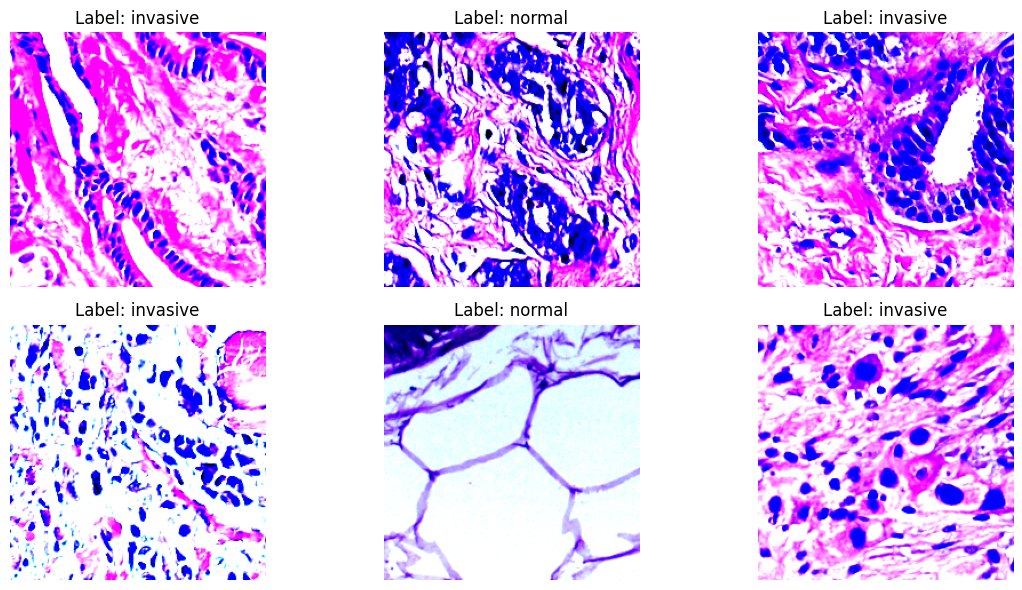

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define a mapping from numerical labels to categories
label_map = {0: "benign", 1: "invasive", 2: 'normal'}

# Assuming you have a batch of data from the training loader
for batch in training_loader:
    images, labels = batch

    # Plotting the images and their labels
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    for i in range(6):
        row = i // 3
        col = i % 3
        img = np.array(images[i].permute(1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions
        axes[row, col].imshow(img)

        # Get the corresponding label category using the mapping
        label_category = label_map[labels[i].item()]

        axes[row, col].set_title(f"Label: {label_category}")
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()
    break  # Display only the first batch


#model

In [7]:
# import torch
# from torch import nn

# def conv_batch(in_num, out_num, kernel_size=3, padding=1, stride=1):
#     return nn.Sequential(
#         nn.Conv2d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
#         nn.BatchNorm2d(out_num),
#         nn.LeakyReLU())


# # Residual block
# class DarkResidualBlock(nn.Module):
#     def __init__(self, in_channels):
#         super(DarkResidualBlock, self).__init__()

#         reduced_channels = int(in_channels/2)

#         self.layer1 = conv_batch(in_channels, reduced_channels, kernel_size=1, padding=0)
#         self.layer2 = conv_batch(reduced_channels, in_channels)

#     def forward(self, x):
#         residual = x

#         out = self.layer1(x)
#         out = self.layer2(out)
#         out += residual
#         return out


# class Darknet53(nn.Module):
#     def __init__(self, block, num_classes):
#         super(Darknet53, self).__init__()

#         self.num_classes = num_classes

#         self.conv1 = conv_batch(3, 32)
#         self.conv2 = conv_batch(32, 64, stride=2)
#         self.residual_block1 = self.make_layer(block, in_channels=64, num_blocks=1)
#         self.conv3 = conv_batch(64, 128, stride=2)
#         self.residual_block2 = self.make_layer(block, in_channels=128, num_blocks=2)
#         self.conv4 = conv_batch(128, 256, stride=2)
#         self.residual_block3 = self.make_layer(block, in_channels=256, num_blocks=8)
#         self.conv5 = conv_batch(256, 512, stride=2)
#         self.residual_block4 = self.make_layer(block, in_channels=512, num_blocks=8)
#         self.conv6 = conv_batch(512, 1024, stride=2)
#         self.residual_block5 = self.make_layer(block, in_channels=1024, num_blocks=4)
#         self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(1024, self.num_classes)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.residual_block1(out)
#         out = self.conv3(out)
#         out = self.residual_block2(out)
#         out = self.conv4(out)
#         out = self.residual_block3(out)
#         out = self.conv5(out)
#         out = self.residual_block4(out)
#         out = self.conv6(out)
#         out = self.residual_block5(out)
#         out = self.global_avg_pool(out)
#         out = out.view(-1, 1024)
#         out = self.fc(out)

#         return out

#     def make_layer(self, block, in_channels, num_blocks):
#         layers = []
#         for i in range(0, num_blocks):
#             layers.append(block(in_channels))
#         return nn.Sequential(*layers)


# def darknet53(num_classes):
#     return Darknet53(DarkResidualBlock, num_classes)

In [8]:
def conv_batch(in_num, out_num, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_num),
        nn.LeakyReLU())

# Residual block
class DarkResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(DarkResidualBlock, self).__init__()

        reduced_channels = int(in_channels/2)

        self.layer1 = conv_batch(in_channels, reduced_channels, kernel_size=1, padding=0)
        self.layer2 = conv_batch(reduced_channels, in_channels)

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        return out

class Darknet53(nn.Module):
    def __init__(self, block, num_classes):
        super(Darknet53, self).__init__()

        self.num_classes = num_classes

        self.conv1 = conv_batch(3, 32)
        self.conv2 = conv_batch(32, 64, stride=2)
        self.residual_block1 = self.make_layer(block, in_channels=64, num_blocks=1)
        self.conv3 = conv_batch(64, 128, stride=2)
        self.residual_block2 = self.make_layer(block, in_channels=128, num_blocks=2)
        self.conv4 = conv_batch(128, 256, stride=2)
        self.residual_block3 = self.make_layer(block, in_channels=256, num_blocks=8)
        self.conv5 = conv_batch(256, 512, stride=2)
        self.residual_block4 = self.make_layer(block, in_channels=512, num_blocks=8)
        self.conv6 = conv_batch(512, 1024, stride=2)
        self.residual_block5 = self.make_layer(block, in_channels=1024, num_blocks=4)

        # Additional linear layers
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, 32)  # New linear layer with output size 32
        self.linear5 = nn.Linear(32, 16)  # New linear layer with output size 16
        self.final_linear = nn.Linear(16, self.num_classes)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.residual_block1(out)
        out = self.conv3(out)
        out = self.residual_block2(out)
        out = self.conv4(out)
        out = self.residual_block3(out)
        out = self.conv5(out)
        out = self.residual_block4(out)
        out = self.conv6(out)
        out = self.residual_block5(out)
        out = self.global_avg_pool(out)
        out = out.view(-1, 1024)

        # Pass through linear layers
        out = nn.functional.relu(self.linear1(out))
        out = nn.functional.relu(self.linear2(out))
        out = nn.functional.relu(self.linear3(out))
        out = nn.functional.relu(self.linear4(out))
        out = nn.functional.relu(self.linear5(out))  # Apply the new linear layer
        out = self.final_linear(out)
        return out

    def make_layer(self, block, in_channels, num_blocks):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels))
        return nn.Sequential(*layers)


def darknet53(num_classes):
    return Darknet53(DarkResidualBlock, num_classes)

In [9]:
num_classes = 3

# Initialize the model
model = darknet53(num_classes)
model.cuda()

Darknet53(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (residual_block1): Sequential(
    (0): DarkResidualBlock(
      (layer1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (layer2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 41186307


In [11]:
print(model)

Darknet53(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (residual_block1): Sequential(
    (0): DarkResidualBlock(
      (layer1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (layer2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

#model resnet

In [7]:
resnet_model = models.resnet50(pretrained=True)
###################################
# Print the structure of the loaded model
print(resnet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
for param in resnet_model.parameters():
    param.requires_grad = False

classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, classes)
# Print the structure of the modified model and notice the difference
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

In [11]:
model = resnet_model

#train

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
############## To Do ##############
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = { 'train': [], 'val': [] }
    loss_hist = { 'train': [], 'val': [] }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                 # Set model to training mode
                model.train()
            else:
                 # Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate outputs, predictions, and losses
                    # Your code ...
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # Your code ...
                        loss.backward()
                        optimizer.step()

                # statistics

                running_loss += loss.item() * inputs.size(0) # Summation of losses
                running_corrects += torch.sum(preds == labels.data) # Summation of true

            epoch_loss = running_loss / len(dataloaders[phase].dataset) # Average of losses. Use running_loss
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset) # Accuracy. Use running_corrects

            if phase == 'val' and not(scheduler is None):
                scheduler.step(epoch_loss) # Set scheduler

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights with the stored state dictionary
    model.load_state_dict(best_model_wts)

    return model, acc_hist, loss_hist
###################################

In [15]:
data_loaders = {'train': training_loader, 'val': validation_loader}

In [ ]:
# model, model_acc, model_loss = train_model(model, data_loaders, criterion, optimizer1, scheduler = None ,num_epochs = 1)

Epoch 0/0
----------
train Loss: 0.4328 Acc: 0.8112
val Loss: 0.4478 Acc: 0.8142

Training complete in 2m 20s
Best val Acc: 0.814186


In [16]:
resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(model, data_loaders, criterion, optimizer1, scheduler=None ,num_epochs = 10)

Epoch 0/9
----------
train Loss: 0.8011 Acc: 0.6367
val Loss: 0.5711 Acc: 0.7830

Epoch 1/9
----------
train Loss: 0.6466 Acc: 0.7127
val Loss: 0.5758 Acc: 0.7378

Epoch 2/9
----------
train Loss: 0.5637 Acc: 0.7630
val Loss: 0.4926 Acc: 0.7986

Epoch 3/9
----------
train Loss: 0.5276 Acc: 0.7808
val Loss: 0.4440 Acc: 0.8108

Epoch 4/9
----------
train Loss: 0.5131 Acc: 0.7878
val Loss: 0.4825 Acc: 0.7917

Epoch 5/9
----------
train Loss: 0.5121 Acc: 0.7895
val Loss: 0.4115 Acc: 0.8368

Epoch 6/9
----------
train Loss: 0.4788 Acc: 0.8060
val Loss: 0.4081 Acc: 0.8368

Epoch 7/9
----------
train Loss: 0.5019 Acc: 0.7917
val Loss: 0.4401 Acc: 0.8333

Epoch 8/9
----------
train Loss: 0.4661 Acc: 0.8056
val Loss: 0.3891 Acc: 0.8542

Epoch 9/9
----------
train Loss: 0.4257 Acc: 0.8290
val Loss: 0.4092 Acc: 0.8299

Training complete in 28m 25s
Best val Acc: 0.854167


In [17]:
#unfreez
for param in resnet_model.parameters():
    param.requires_grad = True

############################
resnet_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
resnet_ft, resnet_acc_ft, resnet_loss_ft = train_model(model, data_loaders, criterion, resnet_optimizer, scheduler=None,num_epochs = 15)
###################################

Epoch 0/14
----------
train Loss: 0.4198 Acc: 0.8355
val Loss: 0.2336 Acc: 0.9097

Epoch 1/14
----------
train Loss: 0.0845 Acc: 0.9744
val Loss: 0.2111 Acc: 0.9323

Epoch 2/14
----------
train Loss: 0.0524 Acc: 0.9792
val Loss: 0.2061 Acc: 0.9392

Epoch 3/14
----------
train Loss: 0.0401 Acc: 0.9878
val Loss: 0.1879 Acc: 0.9392

Epoch 4/14
----------
train Loss: 0.0625 Acc: 0.9792
val Loss: 0.3841 Acc: 0.8924

Epoch 5/14
----------
train Loss: 0.0771 Acc: 0.9774
val Loss: 0.6875 Acc: 0.8299

Epoch 6/14
----------
train Loss: 0.0888 Acc: 0.9696
val Loss: 0.3221 Acc: 0.9097

Epoch 7/14
----------
train Loss: 0.0512 Acc: 0.9818
val Loss: 0.2602 Acc: 0.9288

Epoch 8/14
----------
train Loss: 0.0394 Acc: 0.9861
val Loss: 0.4206 Acc: 0.8889

Epoch 9/14
----------
train Loss: 0.0330 Acc: 0.9891
val Loss: 0.2327 Acc: 0.9444

Epoch 10/14
----------
train Loss: 0.0278 Acc: 0.9913
val Loss: 0.1959 Acc: 0.9410

Epoch 11/14
----------
train Loss: 0.0183 Acc: 0.9948
val Loss: 0.2118 Acc: 0.9427

Ep

#plot

In [18]:
#phase FE
resnet_phase1_train_acc = [tensor.item() for tensor in resnet_acc_fe['train']]
resnet_phase1_val_acc = [tensor.item() for tensor in resnet_acc_fe['val']]

resnet_phase1_train_loss = resnet_loss_fe['train']
resnet_phase1_val_loss = resnet_loss_fe['val']

#phase FT

resnet_phase2_train_acc = [tensor.item() for tensor in resnet_acc_ft['train']]
resnet_phase2_val_acc = [tensor.item() for tensor in resnet_acc_ft['val']]

resnet_phase2_train_loss = resnet_loss_ft['train']
resnet_phase2_val_loss = resnet_loss_ft['val']

In [19]:
train_acc_resnet = resnet_phase1_train_acc + resnet_phase2_train_acc
val_acc_resnet =resnet_phase1_val_acc + resnet_phase2_val_acc
train_loss_resnet=  resnet_phase1_train_loss + resnet_phase2_train_loss
val_loss_resnet =  resnet_phase1_val_loss + resnet_phase2_val_loss

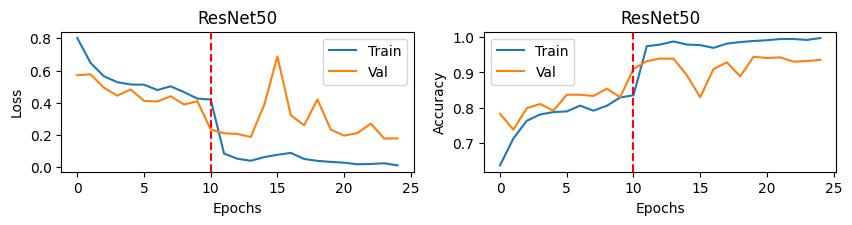

In [20]:
plt.figure(figsize=(10, 4))
#renet
plt.subplot(2, 2, 1)
plt.plot(train_loss_resnet, label='Train')
plt.plot(val_loss_resnet, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50')
plt.legend()
plt.axvline(x=10, color='red', linestyle='--')


plt.subplot(2, 2, 2)
plt.plot(train_acc_resnet, label='Train')
plt.plot(val_acc_resnet, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50')
plt.legend()
plt.axvline(x=10, color='red', linestyle='--')




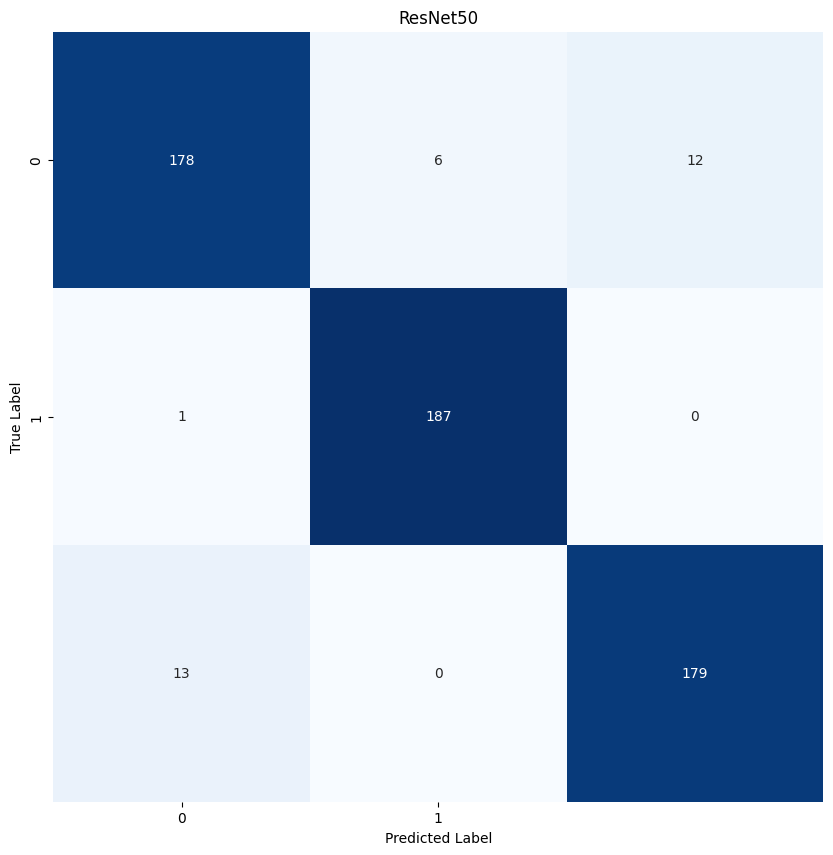

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = [str(i) for i in range(2)]
vgg_predictions = []
resnet_predictions = []
true_labels = []
for _, labels in data_loaders['val']:
    true_labels.extend(labels.tolist())

true_labels = np.array(true_labels)

for inputs, labels in data_loaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    resnet_outputs = resnet_model(inputs)
    _, resnet_preds = torch.max(resnet_outputs, 1)
    resnet_predictions.extend(resnet_preds.cpu().numpy())

resnet_confusion_matrix = confusion_matrix(true_labels, resnet_predictions)

# Plot for ResNet
plt.figure(figsize=(10, 10))
sns.heatmap(resnet_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=classes, yticklabels=classes)
plt.title('ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#test

In [22]:
def acc_calc(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

darknet_accuracy = acc_calc(model, test_loader)

print(f'Model Acc: {darknet_accuracy:.4f}') # ResNet I mean...


Model Acc: 0.9333


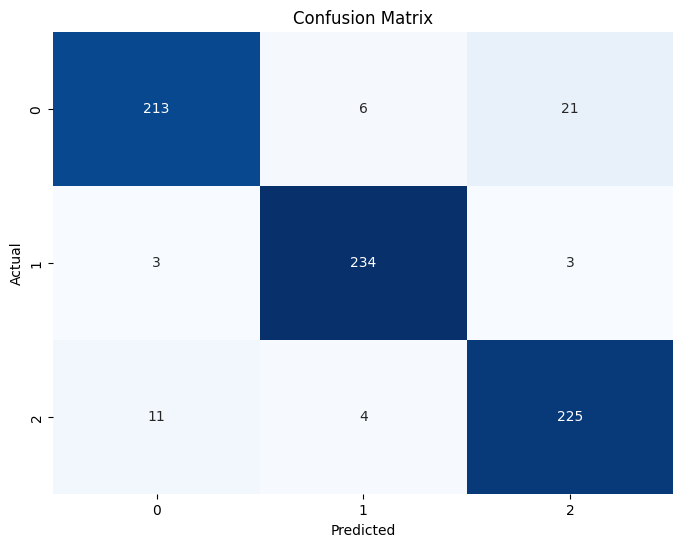

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.metrics import f1_score
import torch

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())  # Append true labels
        predicted_labels.extend(predicted.cpu().numpy())  # Append predicted labels

# Calculate F1 score using accumulated labels
f1score = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'average=None' for per-class F1 scores
print("F1 Score:", f1score)


F1 Score: 0.9331310383283855


#save model

In [24]:
SAVE_PATH = os.path.join("/content/drive/MyDrive", 'resnetBACH' + ".pt")
# save model
torch.save(model, SAVE_PATH)

#load model

In [25]:
model = torch.load('/content/drive/MyDrive/resnetBACH.pt')

#eval

In [26]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

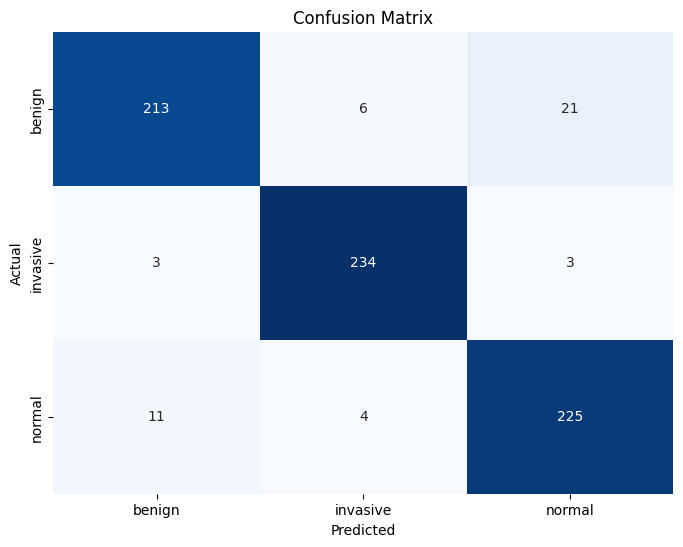

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
predictions = []
ground_truth = []

class_names = ["benign", "invasive", "normal"]  # Replace these with your actual class names

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)

# Plot confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [28]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-gfc6byqd
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-gfc6byqd
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 51ae19245f655cf0ee334db2a945ceb1a4d6df59
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=37432 sha256=b3a333cb26345910fd9a89e41101c85abcb3d8a4bad3a78c1115524c6783a23a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehnr8f7q/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [29]:
import copy
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, HiResCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import requests
import cv2

In [37]:
target_layers = [model.layer4[-1]]

##test1

In [46]:
#test 1,(3) #m

model.eval()

import torch
from torchvision import transforms
from PIL import Image

def predict_probabilities(model, path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(path)
    input_image = transform(image).unsqueeze(0).to(device)  # Add a batch dimension and move to device

    with torch.no_grad():
        output = model(input_image)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities.cpu().numpy()

# Path to the single image
path = '/content/drive/MyDrive/test/benignPatchs512/b024_patch_0_1024.png'
# Load your pre-trained ResNet model
model.eval()

# Ensure the model is on the same device as the input data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get the probabilities for the single image
probabilities = predict_probabilities(model, path)

# Print the probabilities for the single image
print("Probabilities for the Image:")
print(probabilities) #0.99

Probabilities for the Image:
[1.0000000e+00 7.8230183e-10 1.8215040e-08]


In [47]:
#test1 _ b

image_url = '/content/drive/MyDrive/test/benignPatchs512/b024_patch_0_1024.png' #m
img = np.array(Image.open(image_url))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [48]:
targets = [ClassifierOutputTarget(0)]

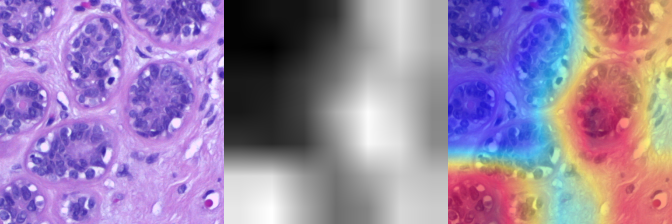

In [50]:
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [54]:
#test2 invasive

image_url = '/content/drive/MyDrive/test/invasivePatchs512/iv100_patch_1024_1024.png' #m
img = np.array(Image.open(image_url))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


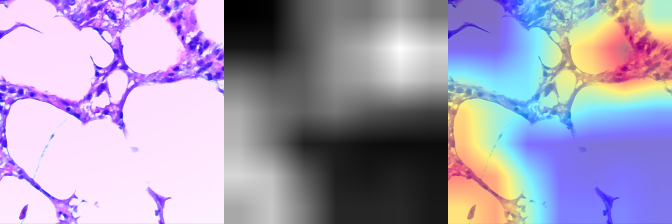

In [55]:
targets = [ClassifierOutputTarget(1)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [61]:
#test3 normal

image_url = '/content/drive/MyDrive/test/normalPatchs512/n048_patch_0_1536.png' #m
img = np.array(Image.open(image_url))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


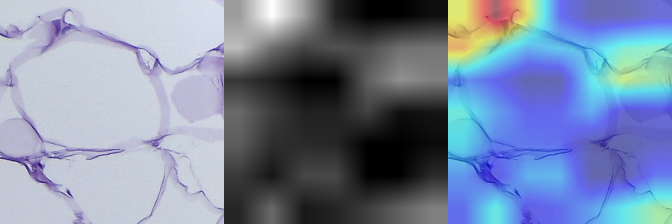

In [63]:
targets = [ClassifierOutputTarget(2)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)